In [56]:
import pandas as pd
pd.options.display.max_rows = None


In [57]:
# Read in protest data 
protests = pd.read_csv("../processed_data/acled_data/protests.csv")
protests.event_date = pd.to_datetime(protests.event_date)
protests = protests.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [58]:
# Minimum and maximum dates
protests.event_date.min(), protests.event_date.max()

(Timestamp('2020-08-09 00:00:00'), Timestamp('2021-04-01 00:00:00'))

In [59]:
# Check that there are no duplicate events
protests.event_id_cnty.duplicated().sum()

0

In [60]:
# Number of protests in all regions 
protests.region_belarus.value_counts()

Minsk         798
Minsk city    360
Grodno        342
Brest         320
Vitebsk       226
Gomel         197
Mogilev       122
Name: region_belarus, dtype: int64

In [61]:
# Replace Minsk city as Minsk
protests["region_belarus"] = protests["region_belarus"].replace('Minsk city', 'Minsk')


In [62]:
# Number of protests in all regions 
protests.region_belarus.value_counts()

Minsk      1158
Grodno      342
Brest       320
Vitebsk     226
Gomel       197
Mogilev     122
Name: region_belarus, dtype: int64

In [63]:
# Top districs with protests
protests.district_belarus.value_counts()[:20]

Minsk           584
Grodno          150
Dzyarzhynsk     138
Barysaw         110
Brest           108
Gomel           103
Vitebsk          96
Lida             92
Polotsk          92
Zhodino          84
Pruzhany         55
Mogilev          55
Baranavichy      48
Maladzyechna     47
Babruysk         44
Salihorsk        43
Vileyka          38
Kobryn           35
Navahrudak       33
Smalyavichy      30
Name: district_belarus, dtype: int64

In [64]:
# Replace missing participation values with 1
protests.protest_size_num.fillna(1, inplace=True)


In [65]:
# Create indicators for small/large protests per district
cols = ["district_belarus", "region_belarus", "event_date", "protest_size_num"]
district_protest = protests.loc[:, cols]

# groupby district and date and summ participants to identify large protests
district_protest = district_protest.groupby(["event_date", "district_belarus", "region_belarus"], as_index=False)["protest_size_num"].sum()


In [66]:
# subscript: 1 = protest size >= 1000, subscript 2 >= 5000, subscript 3 >= 10000
large_protest_cutoffs = [1000, 5000, 10000]
for index, value in enumerate(large_protest_cutoffs):
    district_protest[f"small_protest_{index+1}"] = district_protest.protest_size_num.apply(lambda x: 1 if x < value else 0)
    district_protest[f"large_protest_{index+1}"] = district_protest.protest_size_num.apply(lambda x: 1 if x >= value else 0)

district_protest['district_total_protest'] = district_protest[["small_protest_1", "large_protest_1"]].sum(axis=1)


In [67]:
district_protest.head(2)

,event_date,district_belarus,region_belarus,protest_size_num,small_protest_1,large_protest_1,small_protest_2,large_protest_2,small_protest_3,large_protest_3,district_total_protest
0,2020-08-09,Babruysk,Mogilev,24.0,1,0,1,0,1,0,1
1,2020-08-09,Baranavichy,Brest,10000.0,0,1,0,1,0,1,1


In [68]:
# Number of small and large protests by region 
# Get column names containing '_protest_'
protest_columns = [col for col in district_protest.columns if '_protest_' in col]

# Groupby and get sum of protests in a region 
region_protest = district_protest.groupby(["region_belarus", "event_date"])[protest_columns].agg('sum').reset_index(drop=False)

# Add prefix to columns
# Create a mapping of old names to new names with the prefix
prefix = 'region_num_'
mapping = {col: prefix + col for col in protest_columns}
# Rename the subset of columns with the prefix
region_protest = region_protest.rename(columns=mapping)

In [69]:
region_protest.shape

(935, 8)

In [70]:
# Number of smll and large protests in the country 
country_protest = district_protest.groupby(["event_date"])[protest_columns].agg('sum').reset_index(drop=False)
prefix = 'country_num_'
mapping = {col: prefix + col for col in protest_columns}
# Rename the subset of columns with the prefix
country_protest = country_protest.rename(columns=mapping)


In [71]:
country_protest.shape

(236, 7)

In [72]:
# merge all 3 datasets
protests_combined = district_protest.merge(region_protest, how="left", on=["region_belarus", "event_date"])
protests_combined = protests_combined.merge(country_protest, how="left", on=["event_date"])

In [74]:
protests_combined.head(2)

,event_date,district_belarus,region_belarus,protest_size_num,small_protest_1,large_protest_1,small_protest_2,large_protest_2,small_protest_3,large_protest_3,...,region_num_small_protest_2,region_num_large_protest_2,region_num_small_protest_3,region_num_large_protest_3,country_num_small_protest_1,country_num_large_protest_1,country_num_small_protest_2,country_num_large_protest_2,country_num_small_protest_3,country_num_large_protest_3
0,2020-08-09,Babruysk,Mogilev,24.0,1,0,1,0,1,0,...,2,0,2,0,9,4,10,3,11,2
1,2020-08-09,Baranavichy,Brest,10000.0,0,1,0,1,0,1,...,2,2,3,1,9,4,10,3,11,2


In [75]:
# save this data 
protests_combined.to_csv("../processed_data/acled_data/combined_protest_data.csv", index=False)


<AxesSubplot:xlabel='event_date'>

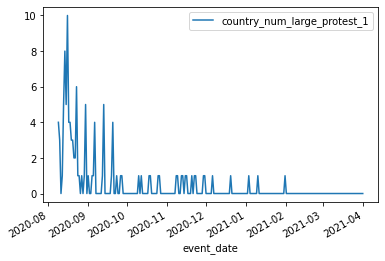

In [55]:
# plot daily protests by region 
protests_combined.plot("event_date","country_num_large_protest_1")


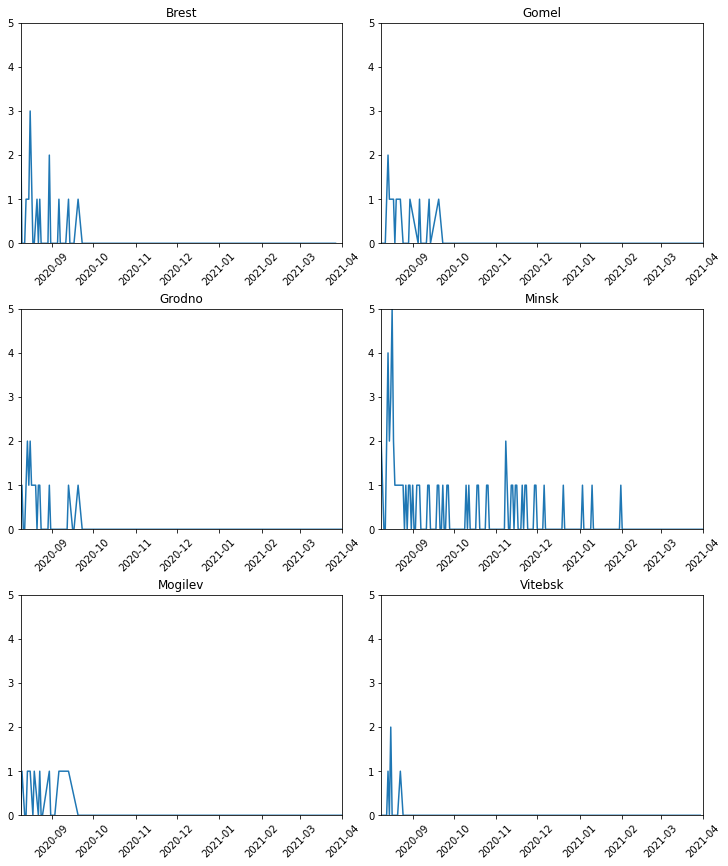

In [213]:
protests_combined.event_date = pd.to_datetime(protests_combined.event_date)
make_subplots(
    num_subplots=6, ncols=2, nrows=3, figsize=(10,12), 
    df=protests_combined, grouping_var="region_belarus", 
    x="event_date", y="region_num_large_protest_1", logy=False, title=""
)

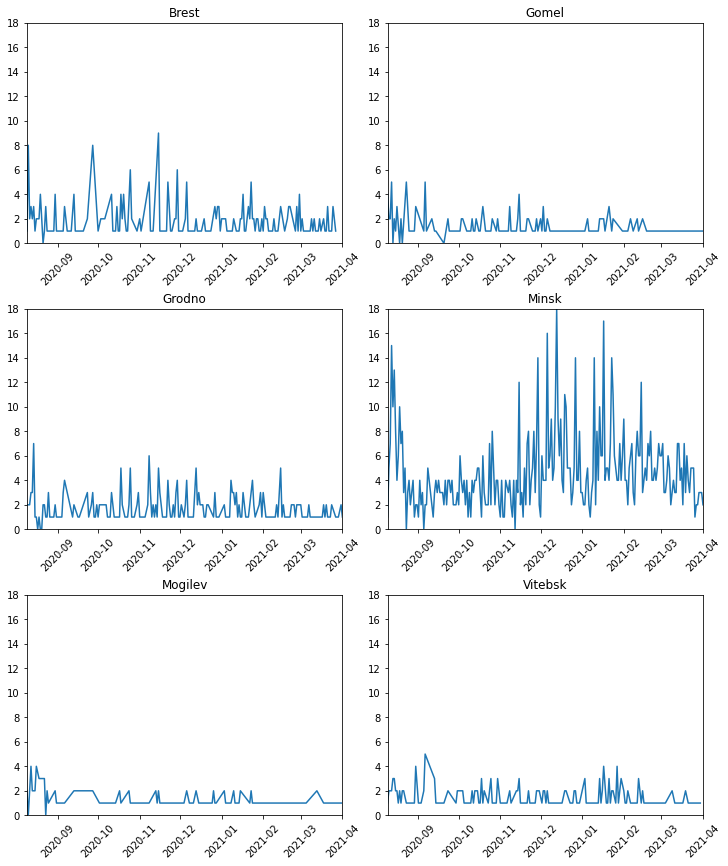

In [212]:
protests_combined.event_date = pd.to_datetime(protests_combined.event_date)
make_subplots(
    num_subplots=6, ncols=2, nrows=3, figsize=(10,12), 
    df=protests_combined, grouping_var="region_belarus", 
    x="event_date", y="region_num_small_protest_1", logy=False, title=""
)